In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from time import time
from sklearn.model_selection import train_test_split
import csv


In [ ]:
#Dataset
#http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip

!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip

In [ ]:
def createConvolutionBlock(inputs, filters, pool=False, dropout=False, dilation=False):
    initializer = 'he_normal'

    if dilation:
        if filters>=32:
            x = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(1,1), kernel_initializer=initializer, padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(2,2), kernel_initializer=initializer, padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(3,3), kernel_initializer=initializer, padding='same')(x)
            x = BatchNormalization()(x)
        else:
            x = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(1,1), kernel_initializer=initializer, padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(2,2), kernel_initializer=initializer, padding='same')(x)
            x = BatchNormalization()(x)           
        
        if pool:
            pl = MaxPooling2D(pool_size=(2, 2))(x)
            if dropout:
                x = Dropout(0.20)(x)
            return x, pl
        else:
            if dropout:
                x = Dropout(0.20)(x)
            return x

    else:
        y = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(1,1), kernel_initializer=initializer, padding='same')(inputs)
        y = BatchNormalization()(y)
        y = Conv2D(filters, (3, 3), activation='relu',dilation_rate=(1,1), kernel_initializer=initializer, padding='same')(y)
        y = BatchNormalization()(y)
        
        if pool:
            pool_ = MaxPooling2D((2,2))(y)
            if dropout:
                y = Dropout(0.20)(y)
            return y, pool_
        else:
            if dropout:
                y = Dropout(0.20)(y)
            return y

In [ ]:
def createDecoderBlock(inputlayer, concatlayer, filters):
    x = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputlayer), concatlayer], axis=3) 
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    return x

In [ ]:
def build_model_architecture(shape, num_classes):
    inputs = Input(shape)

    actv2, pl2 = createConvolutionBlock(inputs, 8, pool=True, dropout=True, dilation=True)
    actv3, pl3 = createConvolutionBlock(pl2, 16, pool=True, dropout=True, dilation=True)
    actv4, pl4 = createConvolutionBlock(pl3, 32, pool=True, dropout=True, dilation=True)
    actv5, pl5 = createConvolutionBlock(pl4, 64, pool=True, dropout=True, dilation=True)
    actv6, pl6 = createConvolutionBlock(pl5, 128, pool=True, dropout=True, dilation=True)


    bridge = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pl6)
    bridge = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bridge)


    dec1 = createDecoderBlock(bridge, actv6, 128)
    dec2 = createDecoderBlock(dec1, actv5, 64)
    dec3 = createDecoderBlock(dec2, actv4, 32)
    dec4 = createDecoderBlock(dec3, actv3, 16)
    dec5 = createDecoderBlock(dec4, actv2, 8)

    output = Conv2D(num_classes, (1,1), padding="same", activation="softmax")(dec5)

    return Model(inputs, output)

In [ ]:
import random


# avg blur minimum filcv2.cvtColor(image, cv2.COLOR_BGR2GRAY)ter size is 3
def avg_blur(img, max_filiter_size = 3) :
	img = img.astype(np.uint8)
	if max_filiter_size >= 3 :
		filter_size = random.randint(3, max_filiter_size)
		if filter_size % 2 == 0 :
			filter_size += 1
		out = cv2.blur(img, (filter_size, filter_size))
	return out

# gaussain blur minimum filter size is 3
# when sigma = 0 gaussain blur weight will compute by program
# when the sigma is more large the blur effect more obvious

def gaussain_blur(img, max_filiter_size = 3, sigma = 0) :
	img = img.astype(np.uint8)
	if max_filiter_size >= 3 :
		filter_size = random.randint(3, max_filiter_size)
		if filter_size % 2 == 0 :
			filter_size += 1
		#print ('size = %d'% filter_size)
		out = cv2.GaussianBlur(img, (filter_size, filter_size), sigma)
	return out

def gaussain_noise(img, mean = 0, var = 0.1) :
	img = img.astype(np.uint8)
	h, w, c = img.shape
	sigma = var ** 0.5
	gauss = np.random.normal(mean, sigma, (h, w, c))
	gauss = gauss.reshape(h, w, c).astype(np.uint8)
	noisy = img + gauss
	return noisy

# fill_pixel is 0(black) or 255(white)
def img_shift(img,mask, x_min_shift_piexl = -1, x_max_shift_piexl = 1, y_min_shift_piexl = -1, y_max_shift_piexl = 1, fill_pixel = 0):
  img = img.astype(np.uint8)
  h, w, c = img.shape
  out = np.zeros(img.shape)
  maskout = np.zeros(mask.shape)
	
  if fill_pixel == 255:
    out[:, :] = 255
  out = out.astype(np.uint8)
  maskout = maskout.astype(np.uint8)
  
  move_x = random.randint(x_min_shift_piexl, x_max_shift_piexl)
  move_y = random.randint(y_min_shift_piexl, y_max_shift_piexl)
 
  if move_x >= 0 and move_y >= 0 :
    out[move_y:, move_x: ] = img[0: (h - move_y), 0: (w - move_x)]
    maskout[move_y:, move_x: ] = mask[0: (h - move_y), 0: (w - move_x)]
  elif move_x < 0 and move_y < 0 :
    out[0: (h + move_y), 0: (w + move_x)] = img[ - move_y:, - move_x:]
    maskout[0: (h + move_y), 0: (w + move_x)] = mask[ - move_y:, - move_x:]
  elif move_x >= 0 and move_y < 0 :
    out[0: (h + move_y), move_x:] = img[ - move_y:, 0: (w - move_x)]
    maskout[0: (h + move_y), move_x:] = mask[ - move_y:, 0: (w - move_x)]
  elif move_x < 0 and move_y >= 0 :
    out[move_y:, 0: (w + move_x)] = img[0 : (h - move_y), - move_x:]
    maskout[move_y:, 0: (w + move_x)] = mask[0 : (h - move_y), - move_x:]
    
  return out,maskout


# In img_flip func. it will random filp image
# when flip factor is 1 it will do hor. flip (Horizontal)
#					  0            ver. flip (Vertical)
#					 -1			   hor. + ver flip
def img_flip(img,mask):
  img = img.astype(np.uint8)
  flip_factor = random.randint(-1, 1)
  out = cv2.flip(img, flip_factor)
  maskout = cv2.flip(mask, flip_factor)
  return out,maskout


# change image contrast by hsv
def img_contrast(img, min_s, max_s, min_v, max_v) :
	img = img.astype(np.uint8)
	hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
	_s = random.randint(min_s, max_s)
	_v = random.randint(min_v, max_v)
	if _s >= 0 :
		hsv_img[:, :, 1] += _s
	else :
		_s = - _s
		hsv_img[:, :, 1] -= _s
	if _v >= 0 :
		hsv_img[:, :, 2] += _v
	else :
		_v = - _v
		hsv_img[:, :, 2] += _v
	out = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
	return out

#Edge enhance
def sharpen_img(img):
    kernel = np.array([[-1,-1,-1,-1,-1],
                    [-1,2,2,2,-1],
                    [-1,2,8,2,-1],
                    [-2,2,2,2,-1],
                    [-1,-1,-1,-1,-1]])/8.0
    result=cv2.filter2D(img,-1,kernel)
    return result


def create_augment_data(arrayimgs,arraymasks,generate_qty):

  auxarrayimgs = arrayimgs.copy()
  auxarraymasks = arraymasks.copy()

  # parameter for data augment functions
  _max_filiter_size = 5 		#for avg_blur and gaussain_blur
  _sigma = 0 					# for gaussain_blur

  _mean = 0 					# for gaussain_noise
  _var = 0.1					# for gaussain_noise

  _x_min_shift_piexl = -20 	# for img_shift
  _x_max_shift_piexl = 20 	# for img_shift
  _y_min_shift_piexl = -20 	# for img_shift
  _y_max_shift_piexl = 20		# for img_shift
  _fill_pixel = 255			# for img_shift


  _min_s = -10				# for img_contrast
  _max_s = 10					# for img_contrast
  _min_v = -10				# for img_contrast
  _max_v = 10					# for img_contrast



  for index in range(len(arrayimgs)):
    generate_quantity = generate_qty
    while generate_quantity > 0:
      
      img = arrayimgs[index]
      mask = arraymasks[index]
			
      if random.randint(0, 1) == 1:
        img = avg_blur(img, _max_filiter_size)

      if random.randint(0, 1) == 1:
        img = gaussain_blur(img, _max_filiter_size, _sigma)

      if random.randint(0, 1) == 1:
        img = gaussain_noise(img, _mean, _var)

      if random.randint(0, 1) == 1:
        img,mask = img_shift(img, mask, _x_min_shift_piexl, _x_max_shift_piexl, _y_min_shift_piexl, _y_max_shift_piexl, _fill_pixel)
        
      if random.randint(0, 1) == 1:
        img,mask = img_flip(img, mask)

      if random.randint(0, 1) == 1:
        img = img_contrast(img, _min_s, _max_s, _min_v, _max_v)

      if random.randint(0, 1) == 1:
        img = sharpen_img(img)
      
      auxarrayimgs.append(img)
      auxarraymasks.append(mask)

      generate_quantity -=1

  return auxarrayimgs, auxarraymasks




In [ ]:
def set_color(pixel,mapping_colors):
  r,g,b = 0,0,0
  for colors in mapping_colors:
    c = colors[0]
    if int(c) == pixel:
      rgb = colors[1]
      r,g,b = rgb[1:len(rgb)-1].split(',')
      break
  return int(r),int(g),int(b)

def mapping_labels_color(img,mapping_colors):
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if img[x,y,0] != 0:
        img[x,y,0],img[x,y,1],img[x,y,2] = set_color(img[x,y,0],mapping_colors)
  return img

def resizeimgsforModel(img,size):
  #auximglist = []
  dim = (size, size)
  #for item in img:
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
  #auximglist.append(resized)
  return resized

def load_dataset(path,IMG_SIZE):
 
  
  imgfile = []
  maskfile = []

  imgtrain = []
  masktrain = []

  imgtest = []
  masktest = []
  
  pathImages = os.listdir(path+"/images/training/")
  pathImages.sort()
  pathMasks = os.listdir(path+"/annotations/training/")
  pathMasks.sort()

  mapping_colors = []
  csv_file =  open('color_coding/color_coding_semantic_segmentation_classes.csv', mode='r')
  csv_reader = csv.DictReader(csv_file)

  for row in csv_reader:
    mapping_colors.append([row['Idx'],row['Color_Code (R,G,B)']])

  for index in range(len(pathImages)):
    imgfile.append(path+"/images/training/"+pathImages[index])
    maskfile.append(path+"/annotations/training/"+pathMasks[index])

  X_train, X_test, y_train, y_test = train_test_split(imgfile, maskfile, test_size=0.2, random_state=42)
  
  #Loading Train
  for imgtr in range(len(X_train)):
    img = cv2.imread(X_train[imgtr])
    imgtrain.append(resizeimgsforModel(img,IMG_SIZE))

    mask = cv2.imread(y_train[imgtr])
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    mask = resizeimgsforModel(mask,IMG_SIZE)
    #mask = mapping_labels_color(mask,mapping_colors)

    masktrain.append(mask)

  
  #Loading Test
  for imgte in range(len(X_test)):
    img = cv2.imread(X_test[imgte])
    imgtest.append(resizeimgsforModel(img,IMG_SIZE))

    mask = cv2.imread(y_test[imgte])
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    mask = resizeimgsforModel(mask,IMG_SIZE)
    #mask = mapping_labels_color(mask,mapping_colors)
    masktest.append(mask)
    
      

  return (imgtrain,masktrain,imgtest,masktest)

def load_data(dataset_path,IMG_SIZE,generate_quantity):
    imgtrain,masktrain,imgtest,masktest = load_dataset(dataset_path,IMG_SIZE)

    #Data augmentation
    #imgtrain,masktrain = create_augment_data(imgtrain,masktrain,generate_quantity)

    imgtrain = np.array(imgtrain)
    masktrain = np.array(masktrain)

    imgtest = np.array(imgtest)
    masktest = np.array(masktest)


    imgtrain = imgtrain.astype(np.float32)
    imgtest = imgtest.astype(np.float32)

    imgtrain = imgtrain / 255.0
    imgtest = imgtest / 255.0

    return (imgtrain, masktrain, imgtest, masktest)

In [ ]:
dataset_path = "ADEChallengeData2016"
IMG_SIZE = 128
generate_quantity = 2

imgtrain,masktrain,imgtest,masktest = load_data(dataset_path,IMG_SIZE,generate_quantity)


In [ ]:
N_CHANNELS = 3
N_CLASSES = 151
batch_size = 100
epochs = 20

train_steps = len(imgtrain) // batch_size
validation_steps = len(imgtest) // batch_size
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
model = build_model_architecture(input_size, N_CLASSES)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)


model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])


In [ ]:

#model.summary()

#$ tensorboard --log_dir=logs/

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


callbacks = [
            ModelCheckpoint("pretreinedmodels/model.val_loss={val_loss:.5f}.h5", monitor='val_loss', verbose=1, save_best_model=True),
            EarlyStopping(monitor="val_loss", patience=5, verbose=1),
            TensorBoard(log_dir="logs/{}".format(time()))
        ]

model.fit(aug.flow(imgtrain, masktrain, batch_size=batch_size),
            steps_per_epoch=train_steps,
            validation_data=(imgtest,masktest),
            validation_steps=validation_steps,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks
        )

Epoch 1/20
  1/161 [..............................] - ETA: 0s - loss: 5.0658 - accuracy: 0.0061WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
137/161 [========================>.....] - ETA: 11s - loss: 3.5730 - accuracy: 0.2076

KeyboardInterrupt: ignored

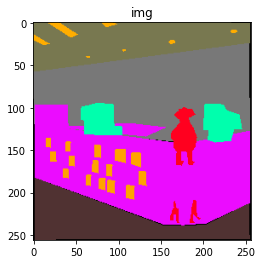

In [ ]:

def set_color(pixel,mapping_colors):
  r,g,b = 0,0,0
  for colors in mapping_colors:
    c = colors[0]
    if int(c) == pixel:
      rgb = colors[1]
      r,g,b = rgb[1:len(rgb)-1].split(',')
      break
  return int(r),int(g),int(b)

def mapping_labels_color(img,mapping_colors):
  for x in range(teste.shape[0]):
    for y in range(teste.shape[1]):
      if img[x,y,0] != 0:
        img[x,y,0],img[x,y,1],img[x,y,2] = set_color(img[x,y,0],mapping_colors)
  return img

import scipy.io

teste = cv2.imread("ADEChallengeData2016/annotations/training/ADE_train_00013367.png")
'''teste = cv2.cvtColor(teste, cv2.COLOR_BGR2GRAY)
colors = scipy.io.loadmat('color150.mat')['colors']
pred_color = colorEncode(teste, colors).astype(np.uint8)

plt.imshow(pred_color)#,cmap='gray')   
plt.title('img') 
plt.show()'''

mapping_colors = []
img_aux = np.zeros((teste.shape),np.uint8)
csv_file =  open('color_coding_semantic_segmentation_classes - Sheet1.csv', mode='r')
csv_reader = csv.DictReader(csv_file)

for row in csv_reader:
  mapping_colors.append([row['Idx'],row['Color_Code (R,G,B)']])


#print(new_color(1,mapping_colors))
for x in range(teste.shape[0]):
  for y in range(teste.shape[1]):
    teste[x,y,0],teste[x,y,1],teste[x,y,2] = new_color(teste[x,y,0],mapping_colors)

plt.imshow(teste)#,cmap='gray')   
plt.title('img') 
plt.show()

